# SFT Vision-Language Assistant for Autonomous Driving: Finetuning Qwen3-VL model on a custom multi-image VL dataset, using QLoRA 4-bit quantization and Transformer Reinforcement Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SarveshBTelang/SFT-Qwen3-Vision-Language-Assistant-for-Autonomous-Driving/blob/main/SFT_VLA_colab_notebook.ipynb)

Dataset: [https://huggingface.co/datasets/SarveshBTelang/SFT_VLA_Dataset_1.0](https://huggingface.co/datasets/SarveshBTelang/SFT_VLA_Dataset_1.0)

Author: Sarvesh Telang

Description:
*   Designed to run on a Google Colab free-tier T4 GPU, the script showcases a resource-efficient strategy for finetuning large vision–language models for video understanding.
*   Provides Full workflow - including dataset loading, model and PEFT adapter configuration, training, and an inference pipeline that extracts frames from a video and uses the finetuned model to answer video-related questions.

*   Instead of processing full video sequences—which would normally require **FlashAttention 2**, available only on A100/Hopper GPUs with support for Turing GPUs) — this approach extracts a fixed number of frames per video, creating sequential-image inputs that are compatible with T4 GPUs while still enabling meaningful temporal reasoning.
*   Utilizes custom dataset **"SarveshBTelang/SFT_VLA_Dataset_1.0"** hosted on the Hugging Face Hub. Each record contains multiple images along with instruction–completion text pairs for supervised finetuning. Images are sourced from **BDD100K** driving videos (http://bdd-data.berkeley.edu/). These images are paired with instructions generated using  **generate_instruction_dataset.ipynb**.

For more details on custom multimodal dataset construction and ETL preprocessing source code, refer to the **main github repository**: [https://github.com/SarveshBTelang/SFT-Qwen3-Vision-Language-Assistant-for-Autonomous-Driving](https://github.com/SarveshBTelang/SFT-Qwen3-Vision-Language-Assistant-for-Autonomous-Driving)

Reference:
- [TRL GitHub Repository](https://github.com/huggingface/trl)
- [Official TRL Examples](https://huggingface.co/docs/trl/example_overview)  
- [More Qwen3-VL Fine-tuning Examples (including TRL scripts)](https://github.com/QwenLM/Qwen3-VL/tree/main/qwen-vl-finetune/)

##### **The codebase is modular and can be adapted to finetune other VL models or image datasets.**

In [ ]:
# -------------------------------
# MOUNT GOOGLE DRIVE
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/drive/MyDrive/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl"

## Install dependencies

Installing **TRL** with the **PEFT** extra, which ensures all main dependencies such as **Transformers** and **PEFT** (a package for parameter-efficient fine-tuning, e.g., LoRA/QLoRA) are included.

Installing **trackio** to log and monitor the experiments, and **bitsandbytes** to enable quantization of LLMs, reducing memory consumption for both inference and training.

Installing opencv for image frames extraction

In [2]:
!pip install -U "trl[peft]" bitsandbytes accelerate peft transformers huggingface_hub datasets opencv-python-headless hf-transfer
# (optional) !pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)


### Log in to Hugging Face

Logging into **Hugging Face** account to save the fine-tuned model. **Access token** can be found on the [account settings page](https://huggingface.co/settings/tokens). Save the token inside the colab secrets as **HF_TOKEN**.

In [3]:
import os
from huggingface_hub import HfApi, login
from google.colab import userdata

token = userdata.get('HF_TOKEN')

if token:
    login(token=token, add_to_git_credential=False)
else:
    raise EnvironmentError(
        "HF_TOKEN is not set in the environment. Please set it before running this script."
    )

### Imports

In [4]:
import torch
from datasets import load_dataset
from transformers import AutoProcessor
from transformers import logging as hf_logging
hf_logging.set_verbosity_info()
from transformers import AutoModelForCausalLM
import cv2
from PIL import Image
from tqdm import tqdm

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

## Load dataset


Loading the custom dataset [**SarveshBTelang/SFT_VLA_Dataset_1.0**](https://huggingface.co/datasets/SarveshBTelang/SFT_VLA_Dataset_1.0) from the Hugging Face Hub using the `datasets` library.


In [5]:
DATASET_ID = "SarveshBTelang/SFT_VLA_Dataset_1.0"
print("Loading dataset:", DATASET_ID)
train_dataset = load_dataset(DATASET_ID, split="train")

def fix_dataset_format(hf_dataset):
    """Ensure prompt and completion are lists. This works with Dataset.map (batched=False)."""
    if isinstance(hf_dataset.get("prompt"), dict):
        hf_dataset["prompt"] = [hf_dataset["prompt"]]
    if isinstance(hf_dataset.get("completion"), dict):
        hf_dataset["completion"] = [hf_dataset["completion"]]
    return hf_dataset

Loading dataset: SarveshBTelang/SFT_VLA_Dataset_1.0


In [6]:
# Required preprocessing step: transforms prompt and completion from dictionaries into lists to conform to the TRL trainer input format.

train_dataset = train_dataset.map(fix_dataset_format)

In [7]:
train_dataset[0] # Check dataset structure for reference

{'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360>],
 'prompt': [{'content': '\nYou are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:\n\n1. Scene Description:\n   - Focus only on elements relevant to driving behavior and safety.\n   - D

## Load model and configure LoRA/QLoRA

By default, this notebook is set up for **QLoRA**, which includes quantization using `BitsAndBytesConfig`. For standard **LoRA** without quantization, comment out the `BitsAndBytesConfig` configuration.

In [8]:
from transformers import Qwen3VLForConditionalGeneration, BitsAndBytesConfig
import torch

model_name = "Qwen/Qwen3-VL-2B-Instruct" # "Qwen/Qwen3-VL-8B-Instruct"

In [9]:
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,                        # Load the model in 4-bit precision to save memory
        bnb_4bit_compute_dtype=torch.float16,     # Data type used for internal computations in quantization
        bnb_4bit_use_double_quant=True,           # Use double quantization to improve accuracy
        bnb_4bit_quant_type="nf4"                 # Type of quantization. "nf4" is recommended for recent LLMs
    )
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen3-VL-2B-Instruct/snapshots/89644892e4d85e24eaac8bacfd4f463576704203/config.json
Model config Qwen3VLConfig {
  "architectures": [
    "Qwen3VLForConditionalGeneration"
  ],
  "image_token_id": 151655,
  "model_type": "qwen3_vl",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "bos_token_id": 151643,
    "dtype": "bfloat16",
    "eos_token_id": 151645,
    "head_dim": 128,
    "hidden_act": "silu",
    "hidden_size": 2048,
    "initializer_range": 0.02,
    "intermediate_size": 6144,
    "max_position_embeddings": 262144,
    "model_type": "qwen3_vl_text",
    "num_attention_heads": 16,
    "num_hidden_layers": 28,
    "num_key_value_heads": 8,
    "rms_norm_eps": 1e-06,
    "rope_scaling": {
      "mrope_interleaved": true,
      "mrope_section": [
        24,
        20,
        20
      ],
      "rope_type": "default"
    },
    "rope_theta": 5000000,


In [10]:
model.gradient_checkpointing_enable()

**Training with LoRA/QLoRA**: Instead of modifying the original weights of **base model**, fine-tuning a **LoRA adapter** — a lightweight layer that enables efficient and memory-friendly training. The `target_modules` specify which parts of the model (e.g., attention or projection layers) will be adapted by LoRA during fine-tuning.

In [11]:
# LoRA config
from peft import LoraConfig
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["down_proj","o_proj","k_proj","q_proj","gate_proj","up_proj","v_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

## Training Configuration

Configure **SFT** using `SFTConfig` (keeping the parameters minimal so the training fits on a free Colab instance). For full details on all available parameters, refer [TRL SFTConfig documentation](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

Before running, store the wandb access key in Colab Secrets with the key name **WANDB_KEY**.

In [12]:
import wandb

# wandb.login(key=os.environ["WANDB_KEY"])
wandb.login(key=userdata.get('WANDB_KEY'))
wandb.init(project="SFT_VLA_qwen3-vl", name="exp_3")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: telang-sarvesh98 (telang-sarvesh98-rptu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
from trl import SFTConfig

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    # Training schedule / optimization
    #num_train_epochs=1,
    max_steps=10,                                         # Number of dataset passes. For full trainings, use `num_train_epochs` instead
    per_device_train_batch_size=1,                        # Batch size per GPU/CPU
    gradient_accumulation_steps=8,                        # Gradients are accumulated over multiple steps → effective batch size = 4 * 8 = 32
    warmup_steps=5,                                       # Gradually increase LR during first N steps
    learning_rate=2e-4,                                   # Learning rate for the optimizer
    optim="adamw_8bit",                                   # Optimizer
    max_length=None,                                      # For VLMs, truncating may remove image tokens, leading to errors during training. max_length=None avoids it

    # Logging / reporting
    output_dir=OUTPUT_DIR,                                # Where to save model checkpoints and logs
    logging_steps=1,                                      # Log training metrics every N steps
    report_to="wandb",                                  # Experiment tracking tool

    # Hub integration
    push_to_hub=False                                     # Set True to push adapters
)

PyTorch: setting up devices


Configure the SFT Trainer: Passing the `training_args`

In [14]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=peft_config,
)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen3-VL-2B-Instruct/snapshots/89644892e4d85e24eaac8bacfd4f463576704203/preprocessor_config.json
loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen3-VL-2B-Instruct/snapshots/89644892e4d85e24eaac8bacfd4f463576704203/preprocessor_config.json
Image processor Qwen2VLImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": null,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "Qwen2VLImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "input_data_format": null,
  "max_pixels": null,
  "merge_size": 2,
  "min_pixels": null,
  "pad_size": null,
  "patch_siz

Show memory stats before training

In [15]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
2.207 GB of memory reserved.


### Training

In [ ]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 151645, 'bos_token_id': None, 'pad_token_id': 151643}.
skipped Embedding(2304, 1024): 2.25M params
skipped Embedding(151936, 2048): 299.0M params
skipped: 299.0M params
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 10
  Number of trainable parameters = 34,865,152
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Show memory stats after training

In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

## Saving fine tuned model

Saving **locally** as well as pushing to the **Hugging Face Hub**

In [ ]:
trainer.save_model(OUTPUT_DIR)
trainer.push_to_hub(dataset_name=OUTPUT_DIR)

In [ ]:
# To download and save into local folder
# !zip -r <OUTPUT_DIR>.zip <OUTPUT_DIR>

## Load the fine-tuned model and run the inference pipeline

In [17]:
# model_name = "Qwen/Qwen3-VL-2B-Instruct"

BASE_MODEL = model_name
ADAPTER_DIR = OUTPUT_DIR + "/checkpoint-10"  # local path to adapter after training
tmp_offload_dir = "/tmp/offload"

print("Base model:", BASE_MODEL)
print("Adapter directory:", ADAPTER_DIR)

Base model: Qwen/Qwen3-VL-2B-Instruct
Adapter directory: /content/drive/MyDrive/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl/checkpoint-10


In [18]:
# Imports
from transformers import Qwen3VLForConditionalGeneration, Qwen3VLProcessor
import torch
import matplotlib.pyplot as plt
import os
from IPython.display import display, Markdown

In [19]:
def load_inference_model(base_model, adapter_path=None, device="cuda", offload_dir=None):
    """
    Load inference model with optional offloading.

    Args:
        base_model: Base model ID or path
        adapter_path: Path to LoRA adapter (optional)
        device: Target device ("cuda" or "cpu")
        offload_dir: Directory for offloading layers to disk (optional)
    """
    # Create offload directory if specified
    if offload_dir is not None:
        os.makedirs(offload_dir, exist_ok=True)

    # Processor (tokenizer + image/video preprocessor)
    processor = Qwen3VLProcessor.from_pretrained(base_model, trust_remote_code=True)

    # Base VL model with optional offloading
    model_kwargs = {
        "device_map": "auto",
        "torch_dtype": torch.float16 if device == "cuda" else torch.float32,
        "trust_remote_code": True
    }

    # Add offload_folder if specified
    if offload_dir is not None:
        model_kwargs["offload_folder"] = offload_dir

    model = Qwen3VLForConditionalGeneration.from_pretrained(
        base_model,
        **model_kwargs
    )

    # Load LoRA adapter (if exists)
    if adapter_path is not None and os.path.exists(adapter_path):
        # Pass device_map and offload_folder to load_adapter to ensure consistency
        model.load_adapter(
            adapter_path
            # Removed device_map and offload_folder from load_adapter as model is already dispatched
        )

    return model, processor, device

In [20]:
# Start loading..

model_inf, proc, dev = load_inference_model(
    BASE_MODEL,
    ADAPTER_DIR,
    offload_dir=tmp_offload_dir
)

print("Done.")

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen3-VL-2B-Instruct/snapshots/89644892e4d85e24eaac8bacfd4f463576704203/preprocessor_config.json
Image processor Qwen2VLImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": null,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "Qwen2VLImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "input_data_format": null,
  "max_pixels": null,
  "merge_size": 2,
  "min_pixels": null,
  "pad_size": null,
  "patch_size": 16,
  "processor_class": "Qwen3VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "longest_edge": 16777216,
    "shortest_edge": 65536
  },

Done.


In [21]:
def count_base_parameters(model):
    base_params = 0
    for name, param in model.named_parameters():
        if "lora" not in name.lower():
            base_params += param.numel()
    return base_params

def count_lora_parameters(model):
    lora_params = 0
    for name, param in model.named_parameters():
        if "lora" in name.lower():
            lora_params += param.numel()
    return lora_params

base_params = count_base_parameters(model_inf)
lora_params = count_lora_parameters(model_inf)

lora_percentage = 100.0 * lora_params / base_params

print(f"Base model parameters : {base_params:,}")
print(f"LoRA adapter params   : {lora_params:,}")
print(f"LoRA as % of base     : {lora_percentage:.4f}%")

Base model parameters : 2,127,532,032
LoRA adapter params   : 34,865,152
LoRA as % of base     : 1.6388%


## Multi-image inference

In [24]:
def run_inference_on_images(model, processor, device, images, user_query):
    """
    Run inference on multiple PIL images using Qwen3-VL.
    """
    num_images = len(images)
    # Construct the image tokens required by Qwen3-VL
    image_tokens = "<|vision_start|>" + "<|image_pad|>" * num_images + "<|vision_end|>"

    # Construct the prompt with the image tokens embedded before the user query.
    prompt_text = f"<|user|>\n{image_tokens}\n{user_query}\n<|assistant|>\n"

    # Processor expects text (string) and images (list)
    inputs = processor(
        images=images,
        text=prompt_text,
        return_tensors="pt"
    ).to(device)

    # Generate output
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=600,
            do_sample=False # Set to false for stable output. Change to true for diverse output.
            # temperature=0.7,
            # top_p=0.8,
            # top_k=20,
        )

    # Decode
    output_text = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )[0]

    # Extract assistant answer cleanly
    if "<|assistant|>" in output_text:
        output_text = output_text.split("<|assistant|>")[-1].strip()

    return output_text

## Video frame extraction

In [25]:
def extract_frames(video_path, max_frames=10, resize_w=640, resize_h=360):
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = torch.linspace(0, total_frames-1, steps=max_frames).int().tolist()

    frames = []
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (resize_w, resize_h))
        img = Image.fromarray(frame)
        frames.append(img)

    cap.release()
    return frames

In [26]:
def display_frames(frames):
    n = len(frames)
    plt.figure(figsize=(4 * n, 4))

    for i, img in enumerate(frames):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(img)
        ax.set_title(f"{i+1}", fontsize=18)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## High level wrapper that accepts a video, question and returns answer

In [22]:
def answer_question_from_video(model, processor, device, video_path, user_query, frames_folder="/tmp/frames", max_frames=10, show_frames=True):
    print("Extracting frames...")
    frames = extract_frames(video_path, max_frames=max_frames, resize_w=640, resize_h=360)
    if show_frames:
        display_frames(frames)
    print("Running model inference...")
    # This will now call the run_inference_on_images function defined in this cell
    answer = run_inference_on_images(model, processor, device, frames, user_query)
    return answer

## Example inference cell

Extracting frames...


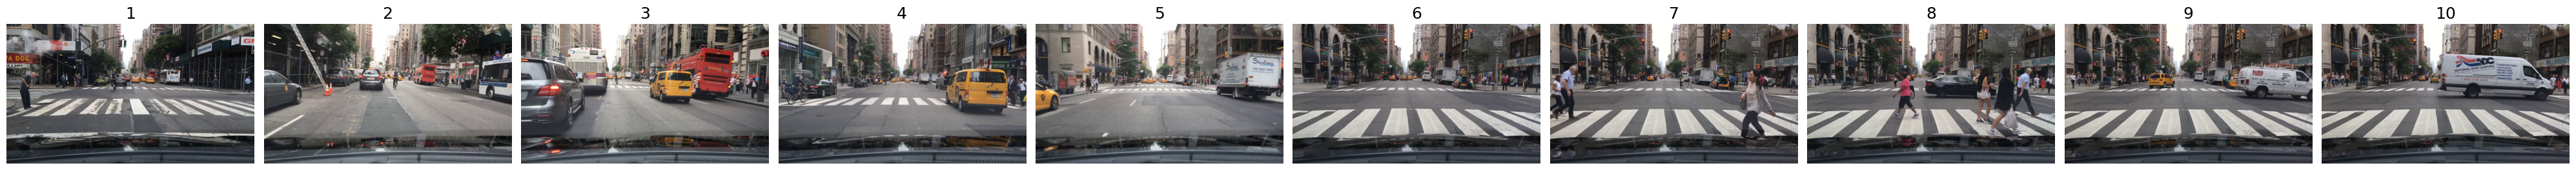

Running model inference...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k'].
- `temperature`: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
- `top_p`: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
- `top_k`: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
If you're using a pretrained model, note that some of these attributes may be set through the model's `generation_config.json` file.


### 👤 User
You are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:1. Scene Description:- Focus only on elements relevant to driving behavior and safety. - Describe the positions, movements, and actions of other vehicles, pedestrians, and obstacles. - Mention traffic signs, lights, road markings, and lane information if relevant. - Highlight any potential hazards or situations that require attention from the ego vehicle.

2. Driving Parameters (JSON):
{
 "road_type": "...",
 "lane_count": "...",
 "ego_lane_position": "...",
 "traffic_light_state": "...",
 "pedestrian_on_road": "...",
 "closest_vehicle_distance": "...",
 "ego_vehicle_speed": "...",
 "road_curvature": "...",
 "weather": "...",
 "visibility": "...",
 "traffic_density": "...",
 "risk_factor": "..."
}

3. Risk Assessment:- Consider nearby vehicles, pedestrians, road conditions, traffic rules, visibility and environmental conditions. Do not mention that it is a video or footage. Provide precise, actionable observations for an ADAS system.

### 🤖 Model Answer
### Scene Description
- **Vehicles**: The scene features a variety of vehicles including taxis, buses, and cars. The taxis are yellow, which is typical for New York City, and they are moving along the street. Buses are also present, indicating public transportation is active. The cars are either stopped at traffic lights or moving slowly due to congestion.
- **Pedestrians**: There are several pedestrians crossing the street, some of whom are waiting at the crosswalks. The pedestrians appear to be following traffic signals and crossing the street safely.
- **Traffic Lights**: Traffic lights are visible at various intersections, controlling the flow of vehicles and pedestrians. The lights are red, indicating that vehicles should stop.
- **Road Markings**: The road has clear markings, including crosswalks and traffic signals. The crosswalks are well-defined, and the traffic signals are clearly visible.
- **Weather**: The weather appears to be clear, with no signs of rain or fog. The sky is bright, suggesting good visibility.
- **Traffic Density**: The traffic density is moderate, with vehicles moving slowly due to congestion. The traffic lights are red, indicating that vehicles should stop.

### Driving Parameters (JSON)
```json
{
  "road_type": "urban",
  "lane_count": 4,
  "ego_lane_position": "left",
  "traffic_light_state": "red",
  "pedestrian_on_road": "yes",
  "closest_vehicle_distance": "100 feet",
  "ego_vehicle_speed": "0 mph",
  "road_curvature": "straight",
  "weather": "clear",
  "visibility": "good",
  "traffic_density": "moderate",
  "risk_factor": "medium"
}
```

### Risk Assessment
- **Nearby Vehicles**: The ego vehicle is approaching a red traffic light, which means it should stop. The closest vehicle is 100 feet away, which is a safe distance.
- **Pedestrians**: There are pedestrians crossing the street, which requires the ego vehicle to yield. The ego vehicle should slow down and stop if necessary.
- **Traffic Lights**: The traffic light is red, indicating that the ego vehicle should stop. The ego vehicle should stop and wait until the light turns green.
- **Road Markings**: The road has clear markings, including crosswalks and traffic signals. The ego vehicle should follow these markings to ensure safe driving.
- **Weather**: The weather is clear, which means there is no risk of rain or fog. The ego vehicle should continue driving safely.
- **Traffic Density**: The traffic density is moderate, which means there are no major hazards. The ego vehicle should proceed cautiously.
- **Risk Factor**: The risk factor is medium, as there are pedestrians crossing the street and traffic lights controlling the flow of vehicles. The ego vehicle should be prepared to stop and yield to pedestrians when necessary.

### Conclusion
The ego vehicle should stop at the red traffic light and wait until the light turns green. The ego vehicle should also be prepared to yield to pedestrians when necessary. The ego vehicle should follow the road markings and traffic signals to ensure safe driving. The risk factor is medium, so the ego vehicle should be cautious and prepared for any potential hazards.

In [17]:
# Trial 1

test_video = "test_1.mov"
user_query = "You are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:1. Scene Description:- Focus only on elements relevant to driving behavior and safety. - Describe the positions, movements, and actions of other vehicles, pedestrians, and obstacles. - Mention traffic signs, lights, road markings, and lane information if relevant. - Highlight any potential hazards or situations that require attention from the ego vehicle.\n\n2. Driving Parameters (JSON):\n{\n \"road_type\": \"...\",\n \"lane_count\": \"...\",\n \"ego_lane_position\": \"...\",\n \"traffic_light_state\": \"...\",\n \"pedestrian_on_road\": \"...\",\n \"closest_vehicle_distance\": \"...\",\n \"ego_vehicle_speed\": \"...\",\n \"road_curvature\": \"...\",\n \"weather\": \"...\",\n \"visibility\": \"...\",\n \"traffic_density\": \"...\",\n \"risk_factor\": \"...\"\n}\n\n3. Risk Assessment:- Consider nearby vehicles, pedestrians, road conditions, traffic rules, visibility and environmental conditions. Do not mention that it is a video or footage. Provide precise, actionable observations for an ADAS system."

if os.path.exists(test_video):
  answer = answer_question_from_video(
      model_inf, proc, dev,
      test_video, user_query,
      max_frames=10
  )

  display(Markdown(f"### 👤 User\n{user_query}"))
  display(Markdown(f"### 🤖 Model Answer\n{answer}"))

else:
    print("Test video not found. To try inference: ensure test_video path is correct and re-run.")

Extracting frames...


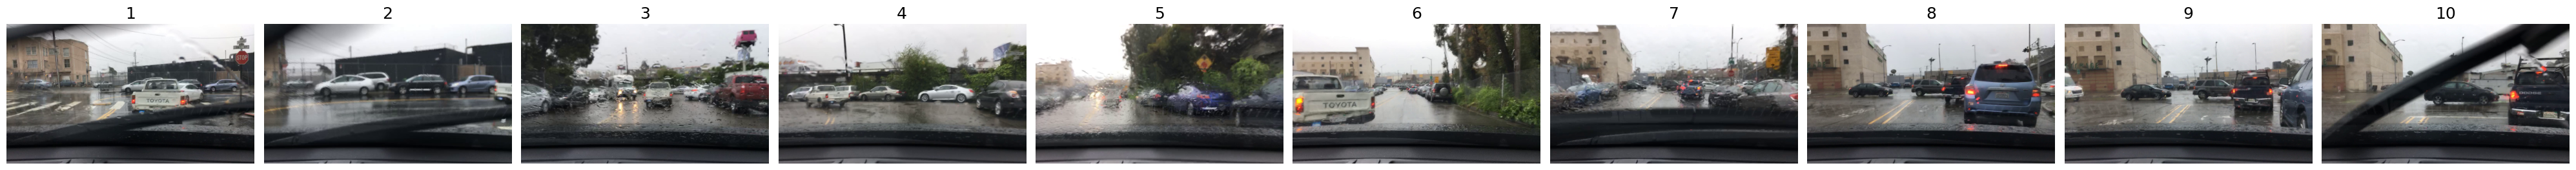

Running model inference...


### 👤 User
You are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:1. Scene Description:- Focus only on elements relevant to driving behavior and safety. - Describe the positions, movements, and actions of other vehicles, pedestrians, and obstacles. - Mention traffic signs, lights, road markings, and lane information if relevant. - Highlight any potential hazards or situations that require attention from the ego vehicle.

2. Driving Parameters (JSON):
{
 "road_type": "...",
 "lane_count": "...",
 "ego_lane_position": "...",
 "traffic_light_state": "...",
 "pedestrian_on_road": "...",
 "closest_vehicle_distance": "...",
 "ego_vehicle_speed": "...",
 "road_curvature": "...",
 "weather": "...",
 "visibility": "...",
 "traffic_density": "...",
 "risk_factor": "..."
}

3. Risk Assessment:- Consider nearby vehicles, pedestrians, road conditions, traffic rules, visibility and environmental conditions. Do not mention that it is a video or footage. Provide precise, actionable observations for an ADAS system.

### 🤖 Model Answer
### Scene Description
- **Vehicles**: The scene shows multiple cars and trucks stopped or moving slowly due to rain. The road appears wet, indicating recent or ongoing rainfall.
- **Traffic Signs**: There are several traffic signs visible, including a stop sign and a yield sign. The stop sign indicates that vehicles must come to a complete stop before proceeding.
- **Pedestrians**: No pedestrians are visible in the scene.
- **Road Markings**: The road has clear lane markings, and the traffic lights are functioning properly.
- **Weather**: The weather appears to be rainy, with visible raindrops on the windshield.
- **Visibility**: Visibility is reduced due to the rain, making it difficult to see clearly ahead.
- **Traffic Density**: The traffic density is moderate, with several vehicles stopped or moving slowly.

### Driving Parameters (JSON)
```json
{
  "road_type": "urban",
  "lane_count": 4,
  "ego_lane_position": "right",
  "traffic_light_state": "red",
  "pedestrian_on_road": false,
  "closest_vehicle_distance": "100 feet",
  "ego_vehicle_speed": "0 mph",
  "road_curvature": "straight",
  "weather": "rainy",
  "visibility": "reduced",
  "traffic_density": "moderate",
  "risk_factor": "high"
}
```

### Risk Assessment
- **Nearby Vehicles**: The ego vehicle is stopped at a red light, and the closest vehicle is 100 feet away. This distance is sufficient to allow for safe stopping.
- **Pedestrians**: No pedestrians are visible, so there is no immediate risk of pedestrian accidents.
- **Road Conditions**: The road is wet, which can affect traction and braking. The ego vehicle should maintain a safe speed and avoid sudden stops.
- **Traffic Density**: The traffic density is moderate, so the ego vehicle should be cautious and prepared for potential delays.
- **Weather**: The rainy weather can reduce visibility and make it difficult to see clearly ahead. The ego vehicle should use its headlights and windshield wipers to improve visibility.
- **Risk Factor**: The risk factor is high due to the combination of reduced visibility, wet road conditions, and moderate traffic density. The ego vehicle should be prepared for potential delays and should maintain a safe speed.

### Recommendations
- **Speed**: Maintain a safe speed, especially when approaching intersections or stop signs.
- **Braking**: Use brakes gently and avoid sudden stops.
- **Visibility**: Use headlights and windshield wipers to improve visibility.
- **Traffic Density**: Be prepared for potential delays and maintain a safe distance from other vehicles.
- **Weather**: Stay alert and be cautious due to the rainy weather conditions.

By following these recommendations, the ego vehicle can ensure a safe and smooth driving experience.

In [27]:
# Trial 2

test_video = "test_2.mov"
user_query = "You are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:1. Scene Description:- Focus only on elements relevant to driving behavior and safety. - Describe the positions, movements, and actions of other vehicles, pedestrians, and obstacles. - Mention traffic signs, lights, road markings, and lane information if relevant. - Highlight any potential hazards or situations that require attention from the ego vehicle.\n\n2. Driving Parameters (JSON):\n{\n \"road_type\": \"...\",\n \"lane_count\": \"...\",\n \"ego_lane_position\": \"...\",\n \"traffic_light_state\": \"...\",\n \"pedestrian_on_road\": \"...\",\n \"closest_vehicle_distance\": \"...\",\n \"ego_vehicle_speed\": \"...\",\n \"road_curvature\": \"...\",\n \"weather\": \"...\",\n \"visibility\": \"...\",\n \"traffic_density\": \"...\",\n \"risk_factor\": \"...\"\n}\n\n3. Risk Assessment:- Consider nearby vehicles, pedestrians, road conditions, traffic rules, visibility and environmental conditions. Do not mention that it is a video or footage. Provide precise, actionable observations for an ADAS system."

if os.path.exists(test_video):
  answer = answer_question_from_video(
      model_inf, proc, dev,
      test_video, user_query,
      max_frames=10
  )

  display(Markdown(f"### 👤 User\n{user_query}"))
  display(Markdown(f"### 🤖 Model Answer\n{answer}"))

else:
    print("Test video not found. To try inference: ensure test_video path is correct and re-run.")

Extracting frames...


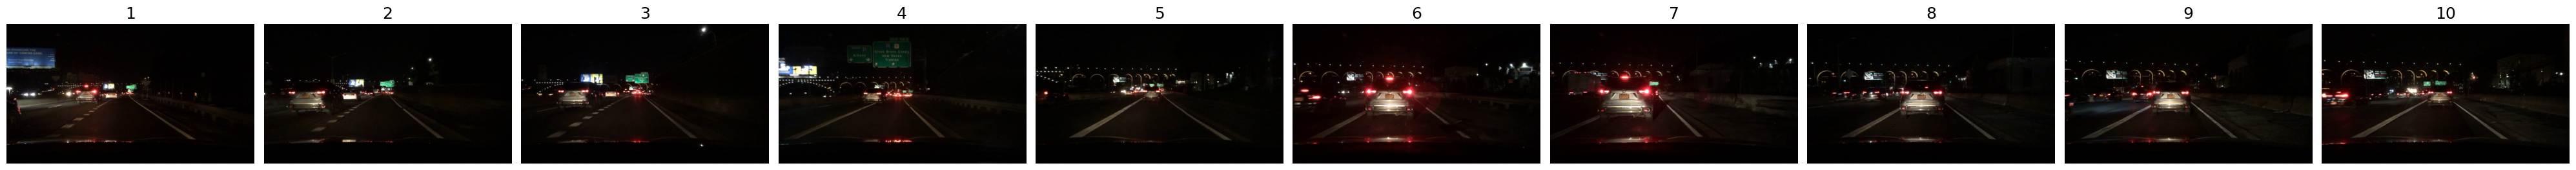

Running model inference...


### 👤 User
You are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:1. Scene Description:- Focus only on elements relevant to driving behavior and safety. - Describe the positions, movements, and actions of other vehicles, pedestrians, and obstacles. - Mention traffic signs, lights, road markings, and lane information if relevant. - Highlight any potential hazards or situations that require attention from the ego vehicle.

2. Driving Parameters (JSON):
{
 "road_type": "...",
 "lane_count": "...",
 "ego_lane_position": "...",
 "traffic_light_state": "...",
 "pedestrian_on_road": "...",
 "closest_vehicle_distance": "...",
 "ego_vehicle_speed": "...",
 "road_curvature": "...",
 "weather": "...",
 "visibility": "...",
 "traffic_density": "...",
 "risk_factor": "..."
}

3. Risk Assessment:- Consider nearby vehicles, pedestrians, road conditions, traffic rules, visibility and environmental conditions. Do not mention that it is a video or footage. Provide precise, actionable observations for an ADAS system.

### 🤖 Model Answer
### Scene Description
- **Vehicles**: The scene depicts a highway at night with multiple lanes of traffic. Several cars are visible, including a silver SUV in the foreground, which appears to be following closely behind another vehicle. The traffic seems to be moving slowly, possibly due to congestion or heavy traffic.
- **Traffic Signs**: There are several traffic signs indicating directions and speed limits. The signs suggest that the road ahead is likely to have multiple lanes and possibly some curves.
- **Road Markings**: The road has clear lane markings, and the ego vehicle is positioned in the right lane. The ego vehicle is following the flow of traffic, maintaining a safe distance from other vehicles.
- **Pedestrians**: There are no pedestrians visible on the road, indicating that the road is primarily used for vehicular traffic.
- **Weather**: The weather appears to be clear, with no signs of rain or fog. The sky is dark, suggesting it is nighttime.
- **Visibility**: Visibility is good, with no obstructions or adverse weather conditions affecting the driver's view.

### Driving Parameters (JSON)
```json
{
  "road_type": "highway",
  "lane_count": 4,
  "ego_lane_position": "right",
  "traffic_light_state": "red",
  "pedestrian_on_road": false,
  "closest_vehicle_distance": "100 feet",
  "ego_vehicle_speed": "20 mph",
  "road_curvature": "straight",
  "weather": "clear",
  "visibility": "good",
  "traffic_density": "moderate",
  "risk_factor": "low"
}
```

### Risk Assessment
- **Nearby Vehicles**: The ego vehicle is following closely behind another vehicle, which suggests that the ego vehicle is maintaining a safe distance. However, the ego vehicle should continue to monitor the distance to ensure it remains safe.
- **Pedestrians**: There are no pedestrians visible on the road, so the ego vehicle does not need to be particularly cautious about pedestrians.
- **Weather**: The weather is clear, which means there are no adverse weather conditions affecting the driver's view.
- **Visibility**: Visibility is good, so the ego vehicle can see clearly ahead and behind.
- **Traffic Density**: The traffic density is moderate, so the ego vehicle should be prepared to adjust its speed and following distance accordingly.
- **Risk Factor**: The risk factor is low, as the ego vehicle is following the flow of traffic and maintaining a safe distance from other vehicles. However, the ego vehicle should continue to monitor the traffic conditions and adjust its speed as needed.

Overall, the ego vehicle appears to be driving safely and following the flow of traffic. The ego vehicle should continue to monitor the traffic conditions and adjust its speed as needed to ensure safety. The ego vehicle should also be prepared to stop if necessary, especially if there are any sudden changes in traffic conditions. The ego vehicle should maintain a safe

In [29]:
# Trial 3

test_video = "test_3.mov"
user_query = "You are an ADAS driving assistant. Analyze the scene from a driving and safety perspective, and produce Scene Description, Driving Parameters and Risk Assessment. Follow below instructions:1. Scene Description:- Focus only on elements relevant to driving behavior and safety. - Describe the positions, movements, and actions of other vehicles, pedestrians, and obstacles. - Mention traffic signs, lights, road markings, and lane information if relevant. - Highlight any potential hazards or situations that require attention from the ego vehicle.\n\n2. Driving Parameters (JSON):\n{\n \"road_type\": \"...\",\n \"lane_count\": \"...\",\n \"ego_lane_position\": \"...\",\n \"traffic_light_state\": \"...\",\n \"pedestrian_on_road\": \"...\",\n \"closest_vehicle_distance\": \"...\",\n \"ego_vehicle_speed\": \"...\",\n \"road_curvature\": \"...\",\n \"weather\": \"...\",\n \"visibility\": \"...\",\n \"traffic_density\": \"...\",\n \"risk_factor\": \"...\"\n}\n\n3. Risk Assessment:- Consider nearby vehicles, pedestrians, road conditions, traffic rules, visibility and environmental conditions. Do not mention that it is a video or footage. Provide precise, actionable observations for an ADAS system."

if os.path.exists(test_video):
  answer = answer_question_from_video(
      model_inf, proc, dev,
      test_video, user_query,
      max_frames=10
  )

  display(Markdown(f"### 👤 User\n{user_query}"))
  display(Markdown(f"### 🤖 Model Answer\n{answer}"))

else:
    print("Test video not found. To try inference: ensure test_video path is correct and re-run.")

In [22]:
# OPTIONAL: To push LoRA Adapters separately to hub

from peft import PeftModel

# Load processor
processor = Qwen3VLProcessor.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True
)

# Load base model
base_model = Qwen3VLForConditionalGeneration.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Attach LoRA adapter
model = PeftModel.from_pretrained(
    base_model,
    ADAPTER_DIR
)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen3-VL-2B-Instruct/snapshots/89644892e4d85e24eaac8bacfd4f463576704203/preprocessor_config.json
Image processor Qwen2VLImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": null,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "Qwen2VLImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "input_data_format": null,
  "max_pixels": null,
  "merge_size": 2,
  "min_pixels": null,
  "pad_size": null,
  "patch_size": 16,
  "processor_class": "Qwen3VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "longest_edge": 16777216,
    "shortest_edge": 65536
  },

In [23]:
REPO_ID = "SarveshBTelang/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl"

model.push_to_hub(REPO_ID)
processor.push_to_hub(REPO_ID)

Uploading the following files to SarveshBTelang/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl: README.md,adapter_model.safetensors,adapter_config.json


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   1%|          | 1.25MB /  140MB            

README.md: 0.00B [00:00, ?B/s]

Image processor saved in /tmp/tmp9o_4jety/preprocessor_config.json
chat template saved in /tmp/tmp9o_4jety/chat_template.jinja
tokenizer config file saved in /tmp/tmp9o_4jety/tokenizer_config.json
Special tokens file saved in /tmp/tmp9o_4jety/special_tokens_map.json
Video processor saved in /tmp/tmp9o_4jety/video_preprocessor_config.json
chat template saved in /tmp/tmp9o_4jety/chat_template.jinja
Uploading the following files to SarveshBTelang/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl: preprocessor_config.json,README.md,tokenizer.json,added_tokens.json,special_tokens_map.json,tokenizer_config.json,merges.txt,video_preprocessor_config.json,chat_template.jinja,vocab.json


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mp9o_4jety/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

CommitInfo(commit_url='https://huggingface.co/SarveshBTelang/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl/commit/1f7cdf5a7f86626eeb44fe2b40fdfc1c38119135', commit_message='Upload processor', commit_description='', oid='1f7cdf5a7f86626eeb44fe2b40fdfc1c38119135', pr_url=None, repo_url=RepoUrl('https://huggingface.co/SarveshBTelang/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl', endpoint='https://huggingface.co', repo_type='model', repo_id='SarveshBTelang/SFT_VLA_Qwen3-VL-2B-Instruct-multimage-trl'), pr_revision=None, pr_num=None)